In [24]:
import numpy as np

In [1]:
cd /content/drive/My Drive/BL/Project/Covid_GNN_PDE/code

/content/drive/My Drive/BL/Project/Covid_GNN_PDE/code


In [2]:
%matplotlib inline

In [3]:
!ls

model_covid_daily.pth	     pdegs	  tmp_covid		 tmp_logs_covid
model_covid.pth		     __pycache__  tmp_covid_daily	 train.py
model_covid_state_daily.pth  test.py	  tmp_covid_state_daily  utils.py


In [4]:
!pip install torch_geometric

     |████████████████████████████████| 194kB 8.2MB/s 
     |████████████████████████████████| 235kB 12.2MB/s 
     |████████████████████████████████| 2.2MB 8.9MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.3-cp36-none-any.whl size=322720 sha256=59a54bf35f6ffbb1e342deb39a7df42382220f1e2af0751f2c8ece0b524ab3cf
  Stored in directory: /root/.cache/pip/wheels/6d/47/1e/0af8ce3e21783c3e584c22502011a3367c091694eebc50a971
Successfully built torch-geometric


In [5]:
!pip install torch_sparse

  Created wheel for torch-sparse: filename=torch_sparse-0.6.8-cp36-cp36m-linux_x86_64.whl size=23316093 sha256=250271499db6e3ac4648e49da3c00dbd8ae91d74dd947a96c8b944f128e27f7b
  Stored in directory: /root/.cache/pip/wheels/31/d3/94/e2560941994bebe665b1dccc69faf33d33aeee2bca353c9bcc
Successfully built torch-sparse


In [6]:
!pip install torch_scatter

  Created wheel for torch-scatter: filename=torch_scatter-2.0.5-cp36-cp36m-linux_x86_64.whl size=11774960 sha256=887f5423a524cab05b6635b9e744d443dd7d5dcba95389054314cceb55f435c3
  Stored in directory: /root/.cache/pip/wheels/42/59/d3/9866e4fd8e1fe9260740acfe22322c428bc0dc064d3ebc456c
Successfully built torch-scatter


In [7]:
!pip install torchdiffeq==0.1.1

In [ ]:
#!pip install torch-geometric \
#  torch-sparse==latest+cu101 \
#  torch-scatter==latest+cu101 \
#  torch-cluster==latest+cu101 \
#  -f https://pytorch-geometric.com/whl/torch-1.4.0.html

In [ ]:
#!pip install torch==1.4.0

In [ ]:
#!pip uninstall torchvision
#!pip install torchvision==0.4.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!mkdir tmp_covid
!mkdir tmp_logs_covid

mkdir: cannot create directory ‘tmp_covid’: File exists
mkdir: cannot create directory ‘tmp_logs_covid’: File exists


In [ ]:
!python train.py

NUMBER OF RANDOM SIMULATIONS : 1
Config(d=40, hs_1=60, hs_2=0, method='euler', rtol=1e-07, atol=1e-07, device='cpu', batch_size=None, lr=1e-06, epochs=1000, model_path='./model_covid.pth', data_path='../data/covid_pkl_train/', tb_log_dir='./tmp_logs_covid/')
Num. of params: 19961
1 / 1
/content/drive/My Drive/BL/Project/Covid_GNN_PDE/code/utils.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  neighbors = np.array(neighbors)[use_nodes]
sim_inds = [0]
dataset length: 1
%%%%%%%%%%%%%%%%%%
Data(edge_index=[2, 19300], pos=[3229, 2], t=[1], x=[3229, 1], y=[180, 3229, 1])
epoch     0 | train loss: 0.000000000000
Plotting...
(1, 3229, 1)
(180, 3229, 1)
torch.Size([1])
torch.Size([3229, 2])
saving./tmp_covid/y_gt_0.png
<Figure size 640x480 with 0 Axes>
<Figure size 1200x60

TRAINING MODEL

In [ ]:
import numpy as np
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from torch_geometric.data import DataLoader

import matplotlib.pyplot as plt

from pdegs.dynamics import DynamicsFunction
from pdegs.integrators import ODEAdjointIntegrator
from pdegs.models import MPNNDiff, Model3

import utils


# Can be replaced by argparse
Config = namedtuple(
    "Config", 
    [
        "d", "hs_1", "hs_2", "method", "rtol", 
        "atol", "device", "batch_size", "lr", 
        "epochs", "model_path", "data_path",
        "tb_log_dir",
    ]
)

args = Config(
    d=40,
    hs_1=60,
    hs_2=0,
    method="euler",  #euler
    rtol=1.0e-7,
    atol=1.0e-7,
    device="cpu", #CHANGE cuda
    batch_size=None,  # Use None for full batch
    lr=0.000001,
    epochs=1000,
    model_path="./model_covid.pth",
    data_path="../data/covid_pkl_train/",
    tb_log_dir="./tmp_logs_covid/",
)

n_s = 1

print("NUMBER OF RANDOM SIMULATIONS :", n_s)

print(args)
device = torch.device(args.device)
writer = SummaryWriter(log_dir=args.tb_log_dir)

# Create model
msg_net = nn.Sequential(
    nn.Linear(4, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.d)
)
aggr_net = nn.Sequential(
    nn.Linear(args.d+1, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, 1)
)
model = MPNNDiff(msg_net, aggr_net)

model.apply(utils.weights_init)
print("Num. of params: {:d}".format(utils.get_parameters_count(model)))

F = DynamicsFunction(model).to(device)

# Create integrator
adj_integr = ODEAdjointIntegrator()

# Prepare data
data = utils.read_pickle(['t', 'x', 'u'], args.data_path)
dataset = utils.generate_torchgeom_dataset(data, sig=0.0)


NUMBER OF RANDOM SIMULATIONS : 1
Config(d=40, hs_1=60, hs_2=0, method='euler', rtol=1e-07, atol=1e-07, device='cpu', batch_size=None, lr=1e-06, epochs=1000, model_path='./model_covid.pth', data_path='../data/covid_pkl_train/', tb_log_dir='./tmp_logs_covid/')
Num. of params: 19961
1 / 1


/content/drive/My Drive/BL/Project/Covid_GNN_PDE/code/utils.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  neighbors = np.array(neighbors)[use_nodes]


In [ ]:
import pickle as pkl
tt = pkl.load(open("../data/covid_pkl_train/t.pkl",'rb'))


In [ ]:
# #########
sim_inds = [0] #np.random.choice(len(dataset), n_s, replace=False)
print(f'sim_inds = {sim_inds}')
dataset = [ds for i, ds in enumerate(dataset) if i in sim_inds]
print(f'dataset length: {len(dataset)}')
# #########

if args.batch_size is None:
    batch_size = len(dataset)

loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Optimizer, loss
optimizer = optim.Rprop(F.parameters(), lr=args.lr)
loss_fn = nn.MSELoss()

# Training
ts = dataset[0].t.shape[0]  # assumes the same time grid for all sim-s.
print("%%%%%%%%%%%%%%%%%%")
print(dataset[0])
for epoch in range(args.epochs):
    losses = torch.zeros(len(loader))
    
    for i, dp in enumerate(loader):
        optimizer.zero_grad()

        params_dict = {"edge_index": dp.edge_index.to(device), "pos": dp.pos.to(device)}
        F.update_params(params_dict)

        y0 = dp.x.to(device)
        t = dp.t[0:ts].to(device)
        y_pd = adj_integr.integrate(
            F, y0, t, method=args.method, rtol=args.rtol, atol=args.atol)
        
        sims = []
        for j in range(batch_size):
            sims.append(dp.y[j*ts:(j+1)*ts])  # TODO: just transpose 0, 1 ?
        y_gt = torch.cat(sims, dim=1)

        loss = loss_fn(y_pd, y_gt.to(device))
        loss.backward()
        optimizer.step()

        losses[i] = loss.item()
        
    writer.add_scalar("train_loss/"+str(args), losses.mean(), epoch)
    
    if epoch % 10 == 0 or epoch == args.epochs - 1:
        print("epoch {:>5d} | train loss: {:>7.12f}".format(epoch, losses.mean()))
        torch.save(F.state_dict(), args.model_path)
    if losses.mean() <= 0.0001:
        break

dp = dataset[0]
params_dict = {"edge_index": dp.edge_index.to(device), "pos": dp.pos.to(device)}
F.update_params(params_dict)
y0 = dp.x.to(device)
t = dp.t[0:ts].to(device)
y_pd = adj_integr.integrate(
    F, y0, t, method=args.method, rtol=args.rtol, atol=args.atol)

print("Plotting...")
print(y_pd.cpu().detach().numpy().shape)
print(dp.y.numpy().shape)
print(dataset[0].t.shape)
print(dataset[0].pos.shape)
plt.figure(0)
utils.plot_fields(
    t=dataset[0].t,
    coords=dataset[0].pos,
    fields={
        "y_pd": y_pd.cpu().detach().numpy(),
        "y_gt": dp.y.numpy(),
    },
    save_path="./tmp_covid/",
    delay=0.0001,
)
plt.show()


sim_inds = [0]
dataset length: 1
%%%%%%%%%%%%%%%%%%
Data(edge_index=[2, 19300], pos=[3229, 2], t=[180], x=[3229, 1], y=[180, 3229, 1])
epoch     0 | train loss: 6229548.500000000000
epoch    10 | train loss: 6229390.500000000000
epoch    20 | train loss: 6229488.500000000000
epoch    30 | train loss: 6229442.500000000000
epoch    40 | train loss: 6229519.000000000000
epoch    50 | train loss: 6229504.500000000000
epoch    60 | train loss: 6229481.000000000000
epoch    70 | train loss: 6229521.000000000000
epoch    80 | train loss: 6229521.000000000000
epoch    90 | train loss: 6229552.500000000000
epoch   100 | train loss: 6229582.000000000000
epoch   110 | train loss: 6229569.500000000000


KeyboardInterrupt: ignored

### Daily cases 

In [ ]:
!mkdir tmp_covid_daily

In [ ]:
!python train.py

NUMBER OF RANDOM SIMULATIONS : 1
Config(d=40, hs_1=60, hs_2=0, method='euler', rtol=1e-07, atol=1e-07, device='cpu', batch_size=None, lr=1e-06, epochs=1000, model_path='./model_covid_daily.pth', data_path='../data/covid_daily_train/', tb_log_dir='./tmp_logs_covid/')
Num. of params: 19961
1 / 1
/content/drive/My Drive/BL/Project/Covid_GNN_PDE/code/utils.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  neighbors = np.array(neighbors)[use_nodes]
sim_inds = [0]
dataset length: 1
%%%%%%%%%%%%%%%%%%
Data(edge_index=[2, 19300], pos=[3229, 2], t=[180], x=[3229, 1], y=[300, 3229, 1])
epoch     0 | train loss: 6242225.000000000000
epoch    10 | train loss: 6242022.000000000000
epoch    20 | train loss: 6241346.500000000000
epoch    30 | train loss: 6237734.500000000000
epoc

Model for states

In [ ]:
!mkdir tmp_covid_state_daily

In [ ]:
!python train.py

NUMBER OF RANDOM SIMULATIONS : 1
Config(d=40, hs_1=60, hs_2=0, method='euler', rtol=1e-07, atol=1e-07, device='cpu', batch_size=None, lr=1e-06, epochs=1000, model_path='./model_covid_state_daily.pth', data_path='../data/covid_state_daily_train/', tb_log_dir='./tmp_logs_covid/')
Num. of params: 19961
1 / 1
/content/drive/My Drive/BL/Project/Covid_GNN_PDE/code/utils.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  neighbors = np.array(neighbors)[use_nodes]
sim_inds = [0]
dataset length: 1
%%%%%%%%%%%%%%%%%%
Data(edge_index=[2, 302], pos=[53, 2], t=[180], x=[53, 1], y=[300, 53, 1])
epoch     0 | train loss: 355105.531250000000
epoch    10 | train loss: 355105.531250000000
epoch    20 | train loss: 355105.531250000000
epoch    30 | train loss: 355105.531250000000
epoc

MODEL for states NORMALIZED

In [8]:
!mkdir tmp_covid_state_daily_norm

In [9]:
!python train.py

NUMBER OF RANDOM SIMULATIONS : 1
Config(d=40, hs_1=60, hs_2=0, method='euler', rtol=1e-07, atol=1e-07, device='cpu', batch_size=None, lr=1e-06, epochs=1000, model_path='./model_covid_state_daily_norm.pth', data_path='../data/covid_state_daily_norm_train/', tb_log_dir='./tmp_logs_covid/')
Num. of params: 19961
1 / 1
/content/drive/My Drive/BL/Project/Covid_GNN_PDE/code/utils.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  neighbors = np.array(neighbors)[use_nodes]
sim_inds = [0]
dataset length: 1
%%%%%%%%%%%%%%%%%%
Data(edge_index=[2, 302], pos=[53, 2], t=[180], x=[53, 1], y=[180, 53, 1])
epoch     0 | train loss: 0.009465565905
epoch    10 | train loss: 0.008942593820
epoch    20 | train loss: 0.006428570487
epoch    30 | train loss: 0.001482372405
epoch    40 | 

In [35]:
!mkdir tmp_covid_state_daily_norm_10k

mkdir: cannot create directory ‘tmp_covid_state_daily_norm_10k’: File exists


In [36]:
!python train.py

NUMBER OF RANDOM SIMULATIONS : 1
Config(d=40, hs_1=60, hs_2=0, method='euler', rtol=1e-07, atol=1e-07, device='cpu', batch_size=None, lr=1e-06, epochs=10000, model_path='./model_covid_state_daily_norm_10k.pth', data_path='../data/covid_state_daily_norm_train/', tb_log_dir='./tmp_logs_covid/')
Num. of params: 19961
1 / 1
/content/drive/My Drive/BL/Project/Covid_GNN_PDE/code/utils.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  neighbors = np.array(neighbors)[use_nodes]
sim_inds = [0]
dataset length: 1
%%%%%%%%%%%%%%%%%%
Data(edge_index=[2, 302], pos=[53, 2], t=[180], x=[53, 1], y=[180, 53, 1])
epoch     0 | train loss: 3.905378341675
epoch    10 | train loss: 3.813869237900
epoch    20 | train loss: 3.548690557480
epoch    30 | train loss: 2.073470354080
epoch    

TESTING

In [10]:
!mkdir state_daily_norm_tmp_fig


In [43]:
!python test.py

(1, 300)
1 / 1
/content/drive/My Drive/BL/Project/Covid_GNN_PDE/code/utils.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  neighbors = np.array(neighbors)[use_nodes]
(300, 53)
(300, 53)
0
test case     0 | test loss: 0.001619667280
Plotting...##########
saving./state_daily_norm_tmp_fig/y_gt_0.png
saving./state_daily_norm_tmp_fig/y_gt_1.png
saving./state_daily_norm_tmp_fig/y_gt_2.png
saving./state_daily_norm_tmp_fig/y_gt_3.png
saving./state_daily_norm_tmp_fig/y_gt_4.png
saving./state_daily_norm_tmp_fig/y_gt_5.png
saving./state_daily_norm_tmp_fig/y_gt_6.png
saving./state_daily_norm_tmp_fig/y_gt_7.png
saving./state_daily_norm_tmp_fig/y_gt_8.png
saving./state_daily_norm_tmp_fig/y_gt_9.png
saving./state_daily_norm_tmp_fig/y_gt_10.png
saving./state_daily_norm_tmp_fig/y

In [34]:
np.savetxt('diff_state_daily_norm.txt', diffs_over_time)

In [38]:
!mkdir state_daily_norm_tmp_fig_10k

mkdir: cannot create directory ‘state_daily_norm_tmp_fig_10k’: File exists


In [41]:
!python test.py

(1, 300)
1 / 1
/content/drive/MyDrive/BL/Project/Covid_GNN_PDE/code/utils.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  neighbors = np.array(neighbors)[use_nodes]
(300, 53)
(300, 53)
0
test case     0 | test loss: 0.001562211197
Plotting...##########
saving./state_daily_norm_tmp_fig_10k/y_gt_0.png
saving./state_daily_norm_tmp_fig_10k/y_gt_1.png
saving./state_daily_norm_tmp_fig_10k/y_gt_2.png
saving./state_daily_norm_tmp_fig_10k/y_gt_3.png
saving./state_daily_norm_tmp_fig_10k/y_gt_4.png
saving./state_daily_norm_tmp_fig_10k/y_gt_5.png
saving./state_daily_norm_tmp_fig_10k/y_gt_6.png
saving./state_daily_norm_tmp_fig_10k/y_gt_7.png
saving./state_daily_norm_tmp_fig_10k/y_gt_8.png
saving./state_daily_norm_tmp_fig_10k/y_gt_9.png
saving./state_daily_norm_tmp_fig_10k/y_g

In [42]:
np.savetxt('diff_state_daily_norm_10k.txt', diffs_over_time)

In [44]:
!ls

data_pos_1.txt			      state_daily_norm_tmp_fig
data_pos.txt			      state_daily_norm_tmp_fig_10k
data_t_1.txt			      state_daily_norm_tmp.npy
data_t.txt			      test.py
diffs.png			      tmp_covid
diff_state_daily_norm_10k.txt	      tmp_covid_daily
diff_state_daily_norm.txt	      tmp_covid_state_daily
grid.png			      tmp_covid_state_daily_norm
model_covid_daily.pth		      tmp_covid_state_daily_norm_10k
model_covid.pth			      tmp_logs_covid
model_covid_state_daily_norm_10k.pth  train.py
model_covid_state_daily_norm.pth      u_gt_1.txt
model_covid_state_daily.pth	      u_gt.txt
pdegs				      u_pred_1.txt
__pycache__			      u_pred.txt
state_daily_norm_tmp_1.npy	      utils.py


OLD

In [ ]:
!mkdir tb_logs_dec12_n750
!mkdir tmp_figs_dec12_n750
!python train.py

mkdir: cannot create directory ‘tb_logs_dec12_n750’: File exists
mkdir: cannot create directory ‘tmp_figs_dec12_n750’: File exists
NUMBER OF RANDOM SIMULATIONS : 24
Config(d=40, hs_1=60, hs_2=0, method='euler', rtol=1e-07, atol=1e-07, device='cpu', batch_size=None, lr=1e-06, epochs=1000, model_path='./model_gnode_n750_run_euler.pth', data_path='../data/subs_paper/convdiff_2pi_n750_t21_train/', tb_log_dir='./tb_logs_dec12_n750/')
Num. of params: 19961
1 / 24
2 / 24
3 / 24
4 / 24
5 / 24
6 / 24
7 / 24
8 / 24
9 / 24
10 / 24
11 / 24
12 / 24
13 / 24
14 / 24
15 / 24
16 / 24
17 / 24
18 / 24
19 / 24
20 / 24
21 / 24
22 / 24
23 / 24
24 / 24
sim_inds = [ 4  8  3  0  1 21 10 14  6 11 13  9 18 16 19 12 23  2 15 17  5  7 22 20]
dataset length: 24
tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000])
epoch     0 | train loss: 0.026897009462
epoch    10 | train loss

In [ ]:
!mkdir tb_logs_dec12_n750
!mkdir tmp_figs_dec12_n750
!python train.py

NUMBER OF RANDOM SIMULATIONS : 24
Config(d=40, hs_1=60, hs_2=0, method='euler', rtol=1e-07, atol=1e-07, device='cpu', batch_size=None, lr=1e-06, epochs=1000, model_path='./model_gnode_n3000_run_euler_1.pth', data_path='../data/subs_paper/convdiff_2pi_n3000_t21_train/', tb_log_dir='./tb_logs_dec12_n3000/')
Num. of params: 19961
1 / 24
2 / 24
3 / 24
4 / 24
5 / 24
6 / 24
7 / 24
8 / 24
9 / 24
10 / 24
11 / 24
12 / 24
13 / 24
14 / 24
15 / 24
16 / 24
17 / 24
18 / 24
19 / 24
20 / 24
21 / 24
22 / 24
23 / 24
24 / 24
sim_inds = [17 19 18  5 16 10 12 20 14  2 22 13  9 11  3  7  6 23  0  8 21  4  1 15]
dataset length: 24
tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000])
epoch     0 | train loss: 0.036522228271
epoch    10 | train loss: 0.035698581487
epoch    20 | train loss: 0.031271558255
epoch    30 | train loss: 0.022765871137
epoch    40 | train loss: 0

In [ ]:
!python -c "import torch; print(torch.__version__)"

1.6.0


In [ ]:
!python test.py

In [ ]:
!ls

comp_dict.npy		     __pycache__	     tmp_figs
diffs.png		     tb_logs		     train_newton.py
model_gnode_n3000_run_4.pth  test_exp_noisy_data.py  train.py
paper_exps		     test_exp_nsim_dep.py    utils.py
pdegs			     test.py


Modified Test file

In [ ]:
!python test.py

In [ ]:
import torch
import torch.nn as nn

from torch_geometric.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt

from pdegs.dynamics import DynamicsFunction
from pdegs.integrators import ODEAdjointIntegrator
from pdegs.models import Model3, MPNNDiff

from collections import namedtuple

import utils


# can be replaced by argparse
Config = namedtuple(
    "Config", 
    [
        "d", "hs_1", "hs_2", "method", "rtol", 
        "atol", "device", "model_path", "data_path"
    ]
)

args = Config(
    d=40,
    hs_1=60,
    hs_2=0,
    method="euler",
    rtol=1.0e-7,
    atol=1.0e-7,
    device="cuda",
    model_path="./model_gnode_n750_run_euler.pth",
    data_path="../data/subs_paper/convdiff_2pi_n750_t21_test/",
)

device = torch.device(args.device)

# Create model
# Model3 
# L1_msg_net = nn.Sequential(nn.Linear(2, args.hs_1), nn.Tanh(), nn.Linear(args.hs_1, args.d))
# L1_aggr_net = nn.Sequential(nn.Linear(args.d, args.hs_1), nn.Tanh(), nn.Linear(args.hs_1, args.d))
# L2_msg_net = nn.Sequential(nn.Linear(4+args.d, args.hs_2), nn.Tanh(), nn.Linear(args.hs_2, args.d))
# L2_aggr_net = nn.Sequential(nn.Linear(args.d, args.hs_2), nn.Tanh(), nn.Linear(args.hs_2, 1))
# model = Model3(L1_msg_net, L1_aggr_net, L2_msg_net, L2_aggr_net)

# MPNN
msg_net = nn.Sequential(
    nn.Linear(4, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.d)
)
aggr_net = nn.Sequential(
    nn.Linear(args.d+1, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, 1)
)
model = MPNNDiff(msg_net, aggr_net)

F = DynamicsFunction(model).to(device)
F.load_state_dict(torch.load(args.model_path, map_location=device))

# Create integrator
adj_integr = ODEAdjointIntegrator()

# Prepare data
data = utils.read_pickle(['t', 'x', 'u'], args.data_path)
print(data['t'].shape)

dataset = utils.generate_torchgeom_dataset(data)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Loss
loss_fn = nn.MSELoss()

# Testing
diffs_over_time = []
losses = torch.zeros(len(loader))

inds_of_sims_to_show = set([])

(50, 61)
1 / 50
2 / 50
3 / 50
4 / 50
5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50
50 / 50


In [ ]:
args = Config(
    d=40,
    hs_1=60,
    hs_2=0,
    method="euler",
    rtol=1.0e-7,
    atol=1.0e-7,
    device="cuda",
    model_path="./model_gnode_n3000_run_4.pth",
    data_path="../data/subs_paper/convdiff_2pi_n3000_t21_test/",
)

In [ ]:
args = Config(
    d=40,
    hs_1=60,
    hs_2=0,
    method="euler",
    rtol=1.0e-7,
    atol=1.0e-7,
    device="cuda",
    model_path="./model_gnode_n1500_run_euler.pth",
    data_path="../data/subs_paper/convdiff_2pi_n1500_t21_test/",
)

In [ ]:
args = Config(
    d=40,
    hs_1=60,
    hs_2=0,
    method="euler",
    rtol=1.0e-7,
    atol=1.0e-7,
    device="cuda",
    model_path="./model_gnode_n750_run_euler.pth",
    data_path="../data/subs_paper/convdiff_2pi_n750_t21_test/",
)

In [ ]:
inds_of_sims_to_show

set()

In [ ]:
!ls

comp_dict.npy			 tb_logs		 tmp_figs_12dec_2
diffs.png			 test1.py		 tmp_figs_12dec_45
grid.png			 test_exp_noisy_data.py  tmp_figs_2
model_gnode_n3000_run_4.pth	 test_exp_nsim_dep.py	 tmp_figs_3
model_gnode_n3000_run_euler.pth  test.py		 train_newton.py
paper_exps			 tmp_figs		 train.py
pdegs				 tmp_figs_1		 utils.py
__pycache__			 tmp_figs_12dec_1


PLOT EVOLUTION HEATMAP

In [ ]:
#!mkdir tmp_figs_n750_48
inds_of_sims_to_show = set([48])
diffs_over_time = []

test case     0 | test loss: 0.000632031122
inds_of_sims_to_show{48}
test case     1 | test loss: 0.000921646366
inds_of_sims_to_show{48}
test case     2 | test loss: 0.001081077382
inds_of_sims_to_show{48}
test case     3 | test loss: 0.001854378730
inds_of_sims_to_show{48}
test case     4 | test loss: 0.001843510661
inds_of_sims_to_show{48}
test case     5 | test loss: 0.000995843788
inds_of_sims_to_show{48}
test case     6 | test loss: 0.000781270850
inds_of_sims_to_show{48}
test case     7 | test loss: 0.000890819996
inds_of_sims_to_show{48}
test case     8 | test loss: 0.000801232003
inds_of_sims_to_show{48}
test case     9 | test loss: 0.000664066465
inds_of_sims_to_show{48}
test case    10 | test loss: 0.001460900181
inds_of_sims_to_show{48}
test case    11 | test loss: 0.001047989354
inds_of_sims_to_show{48}
test case    12 | test loss: 0.000972599839
inds_of_sims_to_show{48}
test case    13 | test loss: 0.000772808213
inds_of_sims_to_show{48}
test case    14 | test loss: 0.001

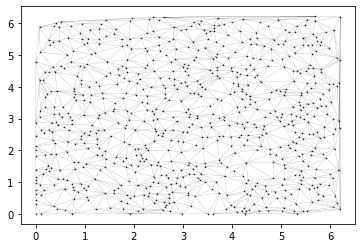

<Figure size 432x288 with 0 Axes>

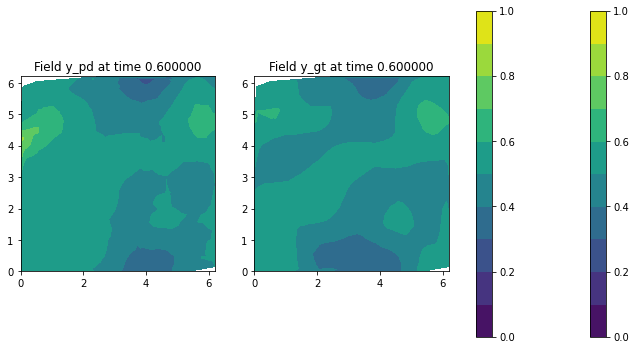

test case    49 | test loss: 0.000705988728
inds_of_sims_to_show{48}


In [ ]:
for i, dp in enumerate(loader):
    params_dict = {"edge_index": dp.edge_index.to(device), "pos": dp.pos.to(device)}
    F.update_params(params_dict)

    y0 = dp.x.to(device)
    t = dp.t.to(device)
    y_pd = adj_integr.integrate(
        F, y0, t, method=args.method, rtol=args.rtol, atol=args.atol)
    
    y_gt = dp.y.to(device)

    loss = loss_fn(y_pd, y_gt)

    losses[i] = loss.item()

    u = y_gt.cpu().detach().numpy()
    u_pd = y_pd.cpu().detach().numpy()
    u_mean = u.mean(axis=1).reshape(-1)

    # diffs = [((u[i] - u_pd[i])**2).mean() for i in range(len(u))]
    
    eps = 1.0e-6
    diffs = [np.linalg.norm(u[i].reshape(-1) - u_pd[i].reshape(-1)) / (np.linalg.norm(u[i].reshape(-1)) + eps) for i in range(len(u))]
    
    diffs_over_time.append(diffs)

    print("test case {:>5d} | test loss: {:>7.12f}".format(i, losses[i]))
    print("inds_of_sims_to_show" + str(inds_of_sims_to_show))
    if i in inds_of_sims_to_show:
        print("Plotting...")
        utils.plot_grid(dataset[i].pos.cpu().detach().numpy())
        plt.figure(0)
        utils.plot_fields(
            t=dataset[i].t,
            coords=dataset[i].pos,
            fields={
                "y_pd": y_pd.cpu().detach().numpy(),
                "y_gt": dp.y.numpy(),
            },
            save_path="./tmp_figs_n750_48/",
            delay=0.0001,
        )
        plt.show()

    # if i == 2:  # 3 for grids, 2 for time points
    #     break



dict_keys(['coords_t_11', 'fields_t_11'])
Plotting diffs...
diffs_over_time.shape (50, 61)
diffs_over_time.mean 0.0575424449452833


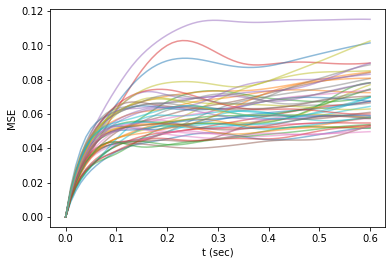

In [ ]:
# comp_dict = np.load("./paper_exps/comp_dict_paper_diff_step_size.npy", allow_pickle='TRUE').item()
comp_dict = {}

comp_dict_upd = {
    # 'coords_true': dataset[2].pos.numpy(), 
    # 'fields_true': dataset[2].y.numpy(),
    'coords_t_11': dataset[2].pos.numpy(),
    'fields_t_11': y_pd.cpu().detach().numpy(),
    
}
comp_dict.update(comp_dict_upd)
np.save("./paper_exps/comp_dict_paper_diff_step_size.npy", comp_dict)
print(comp_dict.keys())

print("Plotting diffs...")
plt.figure(0)
t = dataset[0].t.numpy()

for diff in diffs_over_time:
    #plt.semilogy(t, diff, alpha=0.5)
    plt.plot(t, diff, alpha=0.5)
plt.vlines(0.2, 0, 0.00002, color='gray')

plt.ylabel("MSE")
plt.xlabel("t (sec)")

plt.savefig("diffs_3000_1.png")

diffs_over_time = np.array(diffs_over_time)
print("diffs_over_time.shape", diffs_over_time.shape)
print("diffs_over_time.mean", diffs_over_time.mean())

# save_to = "./plot_data/time_11tpts.npy"
# np.save(save_to, diffs_over_time)

In [ ]:
np.savetxt('diff_file_3000.txt', diffs_over_time)

In [ ]:
import seaborn as sns

In [ ]:
np.savetxt('diff_file', diffs_over_time)


In [ ]:
type(diffs_over_time)

numpy.ndarray

In [ ]:
diffs_over_time

array([[0.        , 0.0194194 , 0.02791274, ..., 0.08682473, 0.08767194,
        0.08847724],
       [0.        , 0.02453216, 0.03858779, ..., 0.08848949, 0.0887732 ,
        0.08883695],
       [0.        , 0.02313244, 0.03413847, ..., 0.20978276, 0.21148917,
        0.2133403 ],
       ...,
       [0.        , 0.02054144, 0.03039766, ..., 0.08654339, 0.08744108,
        0.08826179],
       [0.        , 0.02946224, 0.04813933, ..., 0.07285349, 0.07287394,
        0.07300045],
       [0.        , 0.02506091, 0.03848884, ..., 0.06582805, 0.06623664,
        0.06624442]])

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
df_diff = pd.DataFrame(data=diffs_over_time)

In [ ]:
df_diff[1:2]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
1,0.0,0.024532,0.038588,0.050857,0.059935,0.067754,0.073373,0.078315,0.081501,0.084501,0.08609,0.087762,0.088274,0.089114,0.088942,0.089274,0.088771,0.088844,0.088216,0.088199,0.087492,0.087398,0.086801,0.086766,0.086186,0.08616,0.085697,0.085702,0.085265,0.085293,0.084882,0.084978,0.084685,0.084821,0.084643,0.084874,0.084812,0.085082,0.085051,0.085318,0.085309,0.085607,0.085638,0.085891,0.085946,0.086237,0.086357,0.086621,0.086714,0.086982,0.087082,0.08733,0.087427,0.087677,0.08779,0.088065,0.088161,0.088395,0.088489,0.088773,0.088837


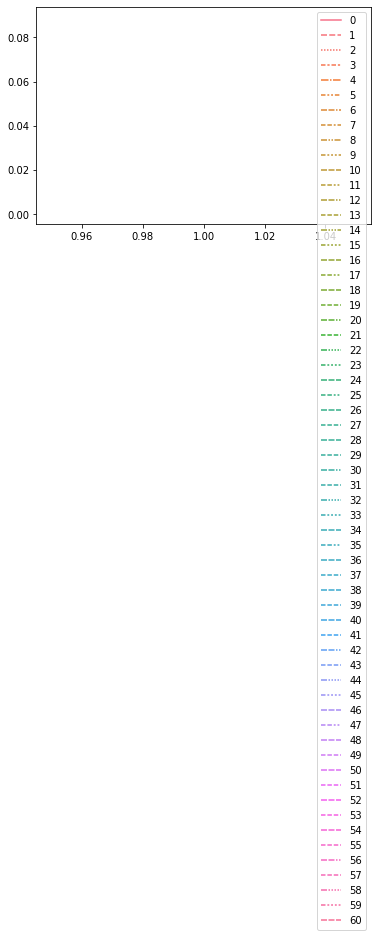

In [ ]:

sns.lineplot(data= df_diff[1:2])

In [ ]:
sns.lineplot(data=fmri, x="timepoint", y="signal", hue="event")

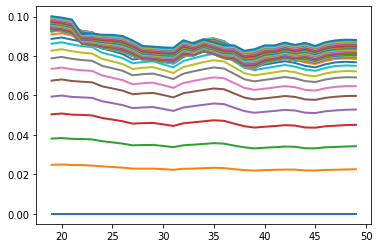

In [ ]:
time_series_df = pd.DataFrame(diffs_over_time)
smooth_path = time_series_df.rolling(20).mean()
path_deviation = time_series_df.rolling(20).std()
plt.plot(smooth_path, linewidth=2)
plt.fill_between(path_deviation.index, (smooth_path-2*path_deviation)[0], (smooth_path+2*path_deviation)[0], color='b', alpha=.1)
